In [545]:
import random
import csv
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# The Task

Traditional pool testing methods are dilutive simple pools which are easy to administer but require retesting the entire pool if there is any positive cases. New studies have shown non-adaptive overlapping pools using combinatorics minimise retesting as well as false negatives. However, they work well only for countries with low virus prevalence. 

1. Design combinatorial pooling and pool size algorithms (in Python) for a population of 300,000 samples and testing capacity of 12,000 tests. Assume a prevalence of 2%, 4%, 6%, 8% and 10%.

2. Compare the amount of savings (assume single test cost USD 100) of overlapping pool versus simple pool versus single test. Which would you recommend?



# Create Samples
Our first step in the process will be to write a function to create our population of samples. We will denote positives with 1s and negatives with 0s. 

In [507]:
# Function which creates a list of positive cases with prevalence (prev) within a population (pop)
def cases_in_popn(prev, pop): 
    # Set random seed
    random.seed(42)
    # Create list of positives and label them as 1s
    num_positives = round(prev * pop)
    positive_cases = [1 for i in range(num_positives)] 
    # Create list of negatives and label them as 0s
    negative_cases = [0 for i in range( pop - num_positives )]
    # Combine both lists and shuffle them. 
    final_pop = random.sample((positive_cases + negative_cases), pop) 
    return final_pop


In [508]:
# Testing the function
cases_in_popn(0.4, 10)


[1, 1, 0, 0, 0, 0, 0, 1, 1, 0]

# Simple Pooling
Simple pooling involves group tests conducted on a "row" of samples(as illustrated in the diagram below). A positive test result indicates that some individual in the corresponding row is infected. Only the specimens sharing a pool with an infected specimen will need to be retested (Verdun et al, 2020).

<img src="../assets/simple.gif" alt="symptoms" width="350"/>


An American research group performed such a test with 12 pools of 5 specimens, each from individuals at risk, and were able to correctly identify the two infected individuals out of the 60 with only 22 tests (Verdun et al, 2020). We'll use similar population and pool size to test our function.    

In [536]:
def simple_pool (prev, pop, pool_size):
    covid_pop = cases_in_popn(prev, pop)
    counter = 0 
    pool = []
    results = []
    total_tests_used = 0
    # First Layer: Test in pools of stated pool_size
    for position in range(len(covid_pop)):
        pool.append(covid_pop[position])
        # Set condition to limit pool size
        cond_limit_pool_size = ((position+1)%pool_size) == 0
        # Set condition to account for final pool which might not reach size limit
        cond_final_pool = (position+1) == len(covid_pop)
        if cond_limit_pool_size or cond_final_pool:
            #print(position+1, pool )
            pool_result = sum(pool)>0
            total_tests_used +=1 # Add to the total tests used counter
            results.append((pool_result, pool))
            pool=[]
    
    # Second Layer: For pools with a positive result, conduct individual sample test
    num_positives =0
    for pool in results:
        if pool[0]==True:
            #print("This pool will be tested individually: ", pool, "\n" )
            total_tests_used += len(pool[1])
            num_positives += sum(pool[1])
    
    # Create df from results
    test_method =  "SIMPLE POOLING"
    data = pd.DataFrame({"test_method": [test_method], "population":["{:,}".format(pop)], "pool_size":[pool_size],
                         "COVID-19 prevalence":[prev], "total_expected_positives": ["{:,}".format(round(prev*pop))] ,
                         "total_positives_found": ["{:,}".format(num_positives)], "total_tests_used":[total_tests_used], 
                         "total_spend(USD)": ["{:,}".format(total_tests_used*100)], "total_saved(USD)": (pop-total_tests_used)*100 })
    
    return data
    
    

In [537]:
# Testing the function
simple_pool (0.033, 60, 5)

,test_method,population,pool_size,COVID-19 prevalence,total_expected_positives,total_positives_found,total_tests_used,total_spend(USD),total_saved(USD)
0,SIMPLE POOLING,60,5,0.033,2,2,22,"2,200",3800


### Analysis
We yielded results similar to the Dorfman test performed by American research group. We'll continue to use this small population to test our overlapping pool function.

# Non-Adaptive Overlapping pools

Overlapping pools involves arrange the population into matrices of n X n size with n being the size of a pool. Here tests are conducted on the row pools and column pools of each matrix as shown in the diagram below. Only the intersection of pools that tested positively will need to be retested(Verdun et al, 2020). In this scenario, only four samples needed to go through the retesting phase. 


<img src="../assets/over.gif" alt="symptoms" width="350"/>

Not all samples will be a square number, we will write a function to extend these samples to a larger square number by adding negative ”dummy samples”(M.Täufer, 2020).


In [511]:
# Create a function to adjust population to fit a n X n grid of samples, where n = pool_size
def form_grids (prev, pop, pool_size):
    covid_pop = cases_in_popn(prev, pop)
    adjusted_total = (pool_size**2) * math.ceil(pop/(pool_size**2))
    diff = adjusted_total-pop
    # Simulating a "padding" of dummy negatives in the population so that an n X n grid can be formed.
    adj_covid_pop = covid_pop + [0 for x in range(diff)]
    
    # Create empty lists to be used in loop
    pool_row = []
    grid = []
    list_of_grids = []
    if pool_size**2 <= len(covid_pop):
        
        for pos in range(len(adj_covid_pop)):
            pool_row.append(adj_covid_pop[pos])
            if (pos+1)%pool_size ==0:
                grid.append(pool_row)
                pool_row=[]
                
            if (pos+1)%(pool_size**2)==0:
                list_of_grids.append(grid)
                grid=[]
    # Accounting for cases where it might be more suitable to use simple pooling
    else:
        print("Error: Overlapping pool tests will not be suitable for a population of", pop, "with pool_size", pool_size)
    return list_of_grids

In [512]:
# Testing the function
form_grids (0.033, 60, 5)

[[[0, 0, 1, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0]]]

In [535]:
# Create function to use overlapping pools on a population
def overlapping_pool(prev, pop, pool_size):
    grids = form_grids(prev, pop, pool_size)
    total_tests_used = (pool_size*2) * len(grids)
    num_positives = 0
    # Loop through list of grids 
    for grid_num in range(len(grids)):
        # getting the row and col results for each n X n grid
        results_rows = [sum(x)>0 for x in grids[grid_num]]
        results_cols = [sum([i[x] for i in grids[grid_num]]) >0 for x in range(pool_size)]
        # Loop through row results and column results 
        for num_row in range(pool_size):
            if results_rows[num_row]:
                for num_col in range(pool_size):
                    if results_cols[num_col]:
                        # Use one test kit for every True-True intersection
                        total_tests_used += 1
                        # If Intersection == 1, add 1 to total positive cases
                        if grids[grid_num][num_row][num_col] == 1:
                            num_positives +=1
    
    # Create df from results
    test_method = "NON-ADAPTIVE OVERLAPPING POOLS"
    data = pd.DataFrame({"test_method": [test_method], "population":["{:,}".format(pop)], "pool_size":[pool_size],
                         "COVID-19 prevalence":[prev], "total_expected_positives": ["{:,}".format(round(prev*pop))] ,
                         "total_positives_found": ["{:,}".format(num_positives)], "total_tests_used":[total_tests_used], 
                         "total_spend(USD)": ["{:,}".format(total_tests_used*100)], "total_saved(USD)": [(pop-total_tests_used)*100] })

    return data


In [514]:
# Testing the function
overlapping_pool(0.033, 60, 5)

,test_method,population,pool_size,COVID-19 prevalence,total_expected_positives,total_positives_found,total_tests_used,total_spend(USD),total_saved(USD)
0,NON-ADAPTIVE OVERLAPPING POOLS,60,5,0.033,2,2,32,"3,200","2,800"


### Analysis
Our function was able to identify our two positives from three 5x5 grids. At this population and pool size, this method uses 10 more test kits compared to simple pooling. 

# Single Test
Here, we will be using a "one-person, one-test" strategy (C.Mentus et al, 2020).

In [533]:
def single_test(prev, pop):  
    
    # Create df from results
    test_method = "SINGLE TEST"
    data = pd.DataFrame({"test_method": [test_method], "population":["{:,}".format(pop)], "pool_size":["N/A"],
                         "COVID-19 prevalence":[prev], "total_expected_positives": ["{:,}".format(round(prev*pop))] ,
                         "total_positives_found": ["{:,}".format(round(prev*pop))], "total_tests_used":[pop], 
                         "total_spend(USD)": ["{:,}".format(pop*100)], "total_saved(USD)": [(pop-pop)*100]})

    return data


In [534]:
# Testing our function
single_test(0.033, 60)

,test_method,population,pool_size,COVID-19 prevalence,total_expected_positives,total_positives_found,total_tests_used,total_spend(USD),total_saved(USD)
0,SINGLE TEST,60,N/A,0.033,2,2,60,"6,000",0


# Comparing Methods
Here, we will compare simple pooling methods against overlapping non-adaptive pooling methods -- and the amount of savings the methods provide versus an extreme method of single-testing the entire population of 300,000 samples. 

In [517]:
# Create a function to compare different methods
def compare_methods(pop, prev_list, pool_list):
    df = pd.DataFrame(columns = (single_test(1, pop)).columns)
    
    for prev in prev_list:
        sing = single_test(prev, pop)
        df = df.append(sing).reset_index(drop=True)
        for pool in pool_list:
            sim = simple_pool(prev, pop, pool)
            df = df.append(sim).reset_index(drop=True)
        for pool in pool_list:
            over = overlapping_pool(prev, pop, pool)
            df = df.append(over).reset_index(drop=True)      
    return df.sort_values(by="total_tests_used")

In [538]:
# Running the function
pd.options.display.float_format = '{:,}'.format
compare_df = compare_methods(300000, [0.02,0.04, 0.06, 0.08, 0.1], [4,8,16,32,64] )
compare_df

,test_method,population,pool_size,COVID-19 prevalence,total_expected_positives,total_positives_found,total_tests_used,total_spend(USD),total_saved(USD)
8,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",16,0.02,"6,000","6,000",63556,"6,355,600",23644400
2,SIMPLE POOLING,"300,000",8,0.02,"6,000","6,000",82244,"8,224,400",21775600
7,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",8,0.02,"6,000","6,000",86085,"8,608,500",21391500
9,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",32,0.02,"6,000","6,000",89328,"8,932,800",21067200
1,SIMPLE POOLING,"300,000",4,0.02,"6,000","6,000",98216,"9,821,600",20178400
3,SIMPLE POOLING,"300,000",16,0.02,"6,000","6,000",101998,"10,199,800",19800200
18,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",8,0.04,"12,000","12,000",104879,"10,487,900",19512100
19,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",16,0.04,"12,000","12,000",110464,"11,046,400",18953600
12,SIMPLE POOLING,"300,000",4,0.04,"12,000","12,000",120252,"12,025,200",17974800
13,SIMPLE POOLING,"300,000",8,0.04,"12,000","12,000",121396,"12,139,600",17860400


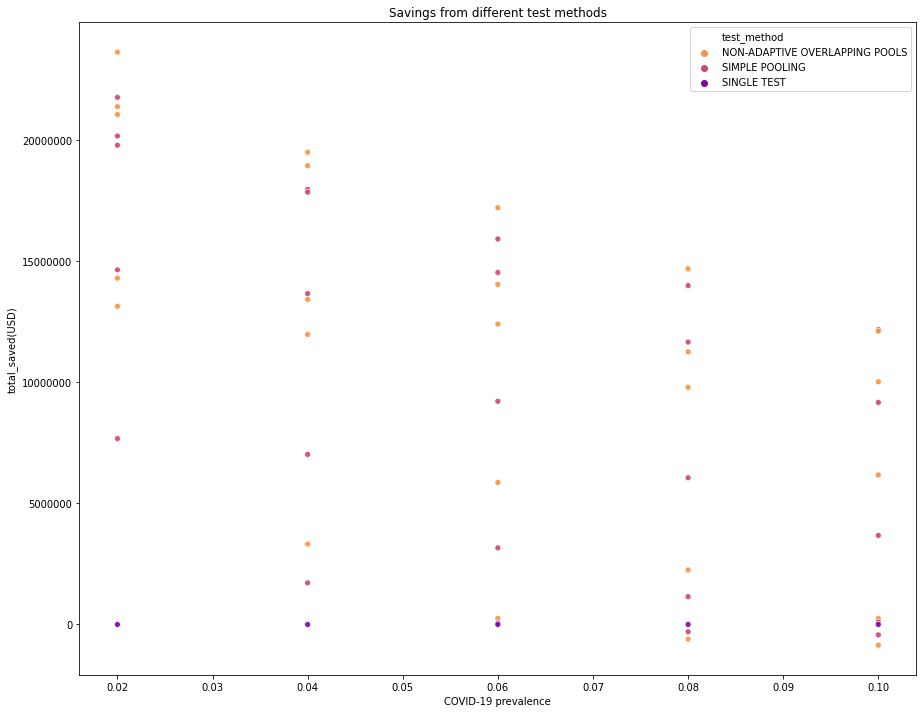

In [583]:
fig = plt.figure(figsize=(15,12))
plt.title("Savings from different test methods")
plt.ticklabel_format(style='plain', axis='y')
sns.scatterplot("COVID-19 prevalence", "total_saved(USD)" , data=compare_df, 
                hue="test_method", palette="plasma_r", alpha=0.9);


### Analysis
- **Pooling Works** - Our comparison reveals that our pooling methods almost always results in cost savings versus a "one-person one-test" strategy. 


- **Overlapping for lower prevalence** - Across most of our prevalence levels, overlapping pools results in higher cost savings versus simple pools. This difference in savings starts to taper as prevalence levels rise. At a prevalence level of 10%, it becomes more cost-efficient to use a simple pooling method.


- **Lack of test kits** - In our comparison, we tested a range of pool sizes as demonstrated by a paper published by UCLA(C.Mentus et al., 2020). Even in our most cost-efficient simulation -- an overlapping pool test in a population with 0.02 prevalence -- we used 63556 to identify the positives within the population. This is more than five times our testing capacity of 12000. 


- **Losses** - In four of our simulations, our methods actually result in losses. These were mainly situations with higher prevalences (0.08, 0.1) and a big pool size(64) -- further driving home the point that pooling methods becomes less cost efficient in populations with higher prevalence. We should also note that it is important to find a method to optimise pool sizes to raise cost-efficiency.


- **Follow-ups** - We'll run some simulations on smaller prevalence numbers to find feasibility ceilings for our methods.  


In [579]:
# Running our function with smaller prevalence figures
small_prev_df = compare_methods(300000, [0.001, 0.002, 0.003], [4,8,16,32,64] )
small_prev_df.head()

,test_method,population,pool_size,COVID-19 prevalence,total_expected_positives,total_positives_found,total_tests_used,total_spend(USD),total_saved(USD)
10,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",64,0.001,300,300,10902,"1,090,200",28909800
21,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",64,0.002,600,600,14244,"1,424,400",28575600
4,SIMPLE POOLING,"300,000",32,0.001,300,300,18719,"1,871,900",28128100
32,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",64,0.003,900,900,19195,"1,919,500",28080500
9,NON-ADAPTIVE OVERLAPPING POOLS,"300,000",32,0.001,300,300,19295,"1,929,500",28070500


### Analysis
**Staying with Budget -- 0.1% prevalence** - Overlapping pools with a pool size of 64 will work within the test capacity of 12000 test kits if the prevalence is kept under 0.1%. 

# Conclusion
- **Overlapping pools recommended for prevalence < 10%** - Our simulations show that pooling methods serve to be effective on populations with low prevalence only. For figures under 10%, we'd recommend the use of overlapping pools. For anything higher, simple pools prove to be more cost-efficient. 


- **Mixed methods** - As pooling methods can actually result in massive savings, it might be worthwhile to employ mixed methods by first splitting the population into symptomatic and asymptomatic. Taking out symptomatic cases theorectically lowers the prevalence in the latter group (C.Mentus et al. , 2020). We can then test symptomatic cases with single tests and the rest with a pooling method. 

<img src="../assets/symp.png" alt="symptoms" width="600"/>

- **Diagonal Overlapping Pool** - Currently, our overlapping pool method only tests our rows and columns. Efficiency might improve if we add an additional diagonal pool (M.Täufer, 2020).
<img src="../assets/diag.png" alt="symptoms" width="600"/>


# References


- Verdun, Claudio M., et al. “Group Testing for SARS-CoV-2 Allows for up to 10-Fold Efficiency Increase across Realistic Scenarios and Testing Strategies.” *MedRxiv*, Cold Spring Harbor Laboratory Press, 1 Jan. 2020, www.medrxiv.org/content/10.1101/2020.04.30.20085290v2.



- Ben-Ami, Roni, et al. “Large-Scale Implementation of Pooled RNA-Extraction and RT-PCR for SARS-CoV-2 Detection.” 2020, doi:10.1101/2020.04.17.20069062.



- Täufer, Matthias. “Rapid, Large-Scale, and Effective Detection of COVID-19 ...” *MedRxiv*, www.biorxiv.org/content/10.1101/2020.04.06.028431v1.



- Mentus, Cassidy, et al. “Analysis and Applications of Adaptive Group Testing Methods for COVID-19.” *MedRxiv*, Cold Spring Harbor Laboratory Press, 1 Jan. 2020, doi.org/10.1101/2020.04.05.20050245.

